In [1]:
import os
os.chdir('../..')
!ls

future_trade


In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
%matplotlib inline

sns.set()
sns.set_style("whitegrid") 
%config InlineBackend.figure_format = 'retina'

In [3]:
# lancet - totals are in tonnes, per day measures are in grams
# fao - area in ha, rest in tonnes

In [4]:
categories_dict = {
    'wheat': ['jwhea'],
    'rice' : ['jrice'],
    'maize' : ['jmaiz'],
    'othr_grains' : ['jbarl', 'jmill', 'jsorg', 'jocer'],
    'roots' : ['jcass', 'jpota', 'jswpt', 'jyams', 'jorat'],
    'vegetables' : ['jvege'],
    'fruits' : ['jbana', 'jplnt', 'jsubf', 'jtemf'],
    'legumes' : ['jbean', 'jchkp', 'jcowp', 'jlent', 'jpigp', 'jopul'],
    'soybeans' : ['jsoyb'],
    'nuts_seeds' : ['jgrnd', 'jothr'],
    'oil_veg' : ['jrpsd', 'jsnfl', 'jtols'],
    'oil_palm' : ['jpalm'],
    'sugar' : ['jsugb', 'jsugc']
}

In [13]:
df_list = []
cons_lancet_all = pd.read_csv('../../OPSIS/Data/Future_production_demand_data/demand_scn_food_feed_other.csv') # lancet scenarios with feed and other included

for category in categories_dict.keys():
    impact_cats = categories_dict[category]
    
    # fao rebalanced data
    cons_fao_bal = pd.concat([pd.read_parquet(
        f'../../OPSIS/Data/FAOSTAT/combined_data/combined_inputs_country_{cat}.parquet.gzip') for cat in impact_cats],
                             axis=0, ignore_index=True)

    cons_fao_bal = cons_fao_bal.groupby('Abbreviation')[['Area', 'Production', 'imports', 'exports', 'Consumption']].sum().reset_index()
    
    cons_lancet = cons_lancet_all[
        (cons_lancet_all['kcal_scn']=='2100kcal')
        & (cons_lancet_all['food_group']==category)
        & (cons_lancet_all['diet_scn']=='BMK')
        & (cons_lancet_all['year']==2020)
    ]
    
    cons_lancet = cons_lancet[['region', 'food_group', 'food_lancet_total_est', 'feed_lancet_total_est', 'other_lancet_total_est']]
    cons_lancet['cons_lancet_total_est'] = cons_lancet['food_lancet_total_est'] + cons_lancet['feed_lancet_total_est'] + cons_lancet['other_lancet_total_est']
    cons = cons_lancet.merge(cons_fao_bal, left_on='region', right_on='Abbreviation').drop(['Area', 'Abbreviation'], axis=1)
    df_list.append(cons)
    
cons_all = pd.concat(df_list, axis=0, ignore_index=True)

In [14]:
cons_all.shape

(1989, 10)

In [16]:
cons_all.head()

,region,food_group,food_lancet_total_est,feed_lancet_total_est,other_lancet_total_est,cons_lancet_total_est,Production,imports,exports,Consumption
0,AFG,wheat,3.867559e+06,7.861150e+05,7.252614e+05,5.378935e+06,4397346.60,2.585291e+06,2.326950e+00,6.982635e+06
1,AGO,wheat,9.038280e+05,6.337303e+05,3.426576e+04,1.571824e+06,2939.71,7.686919e+05,0.000000e+00,7.716316e+05
2,ALB,wheat,2.889880e+05,2.442003e+05,1.586818e+05,6.918702e+05,241397.98,2.259389e+05,7.904797e+01,4.672579e+05
3,ARG,wheat,3.623284e+06,2.258807e+06,1.102025e+06,6.984117e+06,18758819.40,2.974492e+01,1.163202e+07,7.126834e+06
4,ARM,wheat,2.788150e+05,1.204138e+05,4.908995e+04,4.483187e+05,141122.66,3.201970e+05,1.660284e+02,4.611536e+05


In [18]:
def get_corr(df, X, Y):
    return df[[X, Y]].corr()[X][Y]

cons_all.groupby('food_group').apply(lambda g: get_corr(g, "Consumption", "cons_lancet_total_est"))

food_group
fruits         0.947987
legumes        0.680705
maize          0.960851
nuts_seeds     0.887515
oil_palm       0.496441
oil_veg        0.894348
othr_grains    0.723563
rice           0.983684
roots          0.964157
soybeans       0.892859
sugar          0.864110
vegetables     0.995399
wheat          0.959204
dtype: float64

In [21]:
cons_all['log_cons_lancet'] = np.log(cons_all['cons_lancet_total_est']+1)
cons_all['log_cons_fao'] = np.log(cons_all['Consumption']+1)
cons_all.groupby('food_group').apply(lambda g: get_corr(g, "log_cons_fao", "log_cons_lancet"))

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


food_group
fruits         0.942256
legumes        0.815143
maize          0.827045
nuts_seeds     0.598474
oil_palm       0.561976
oil_veg        0.580589
othr_grains    0.842468
rice           0.936240
roots          0.939713
soybeans       0.728167
sugar          0.823374
vegetables     0.968077
wheat          0.947136
dtype: float64

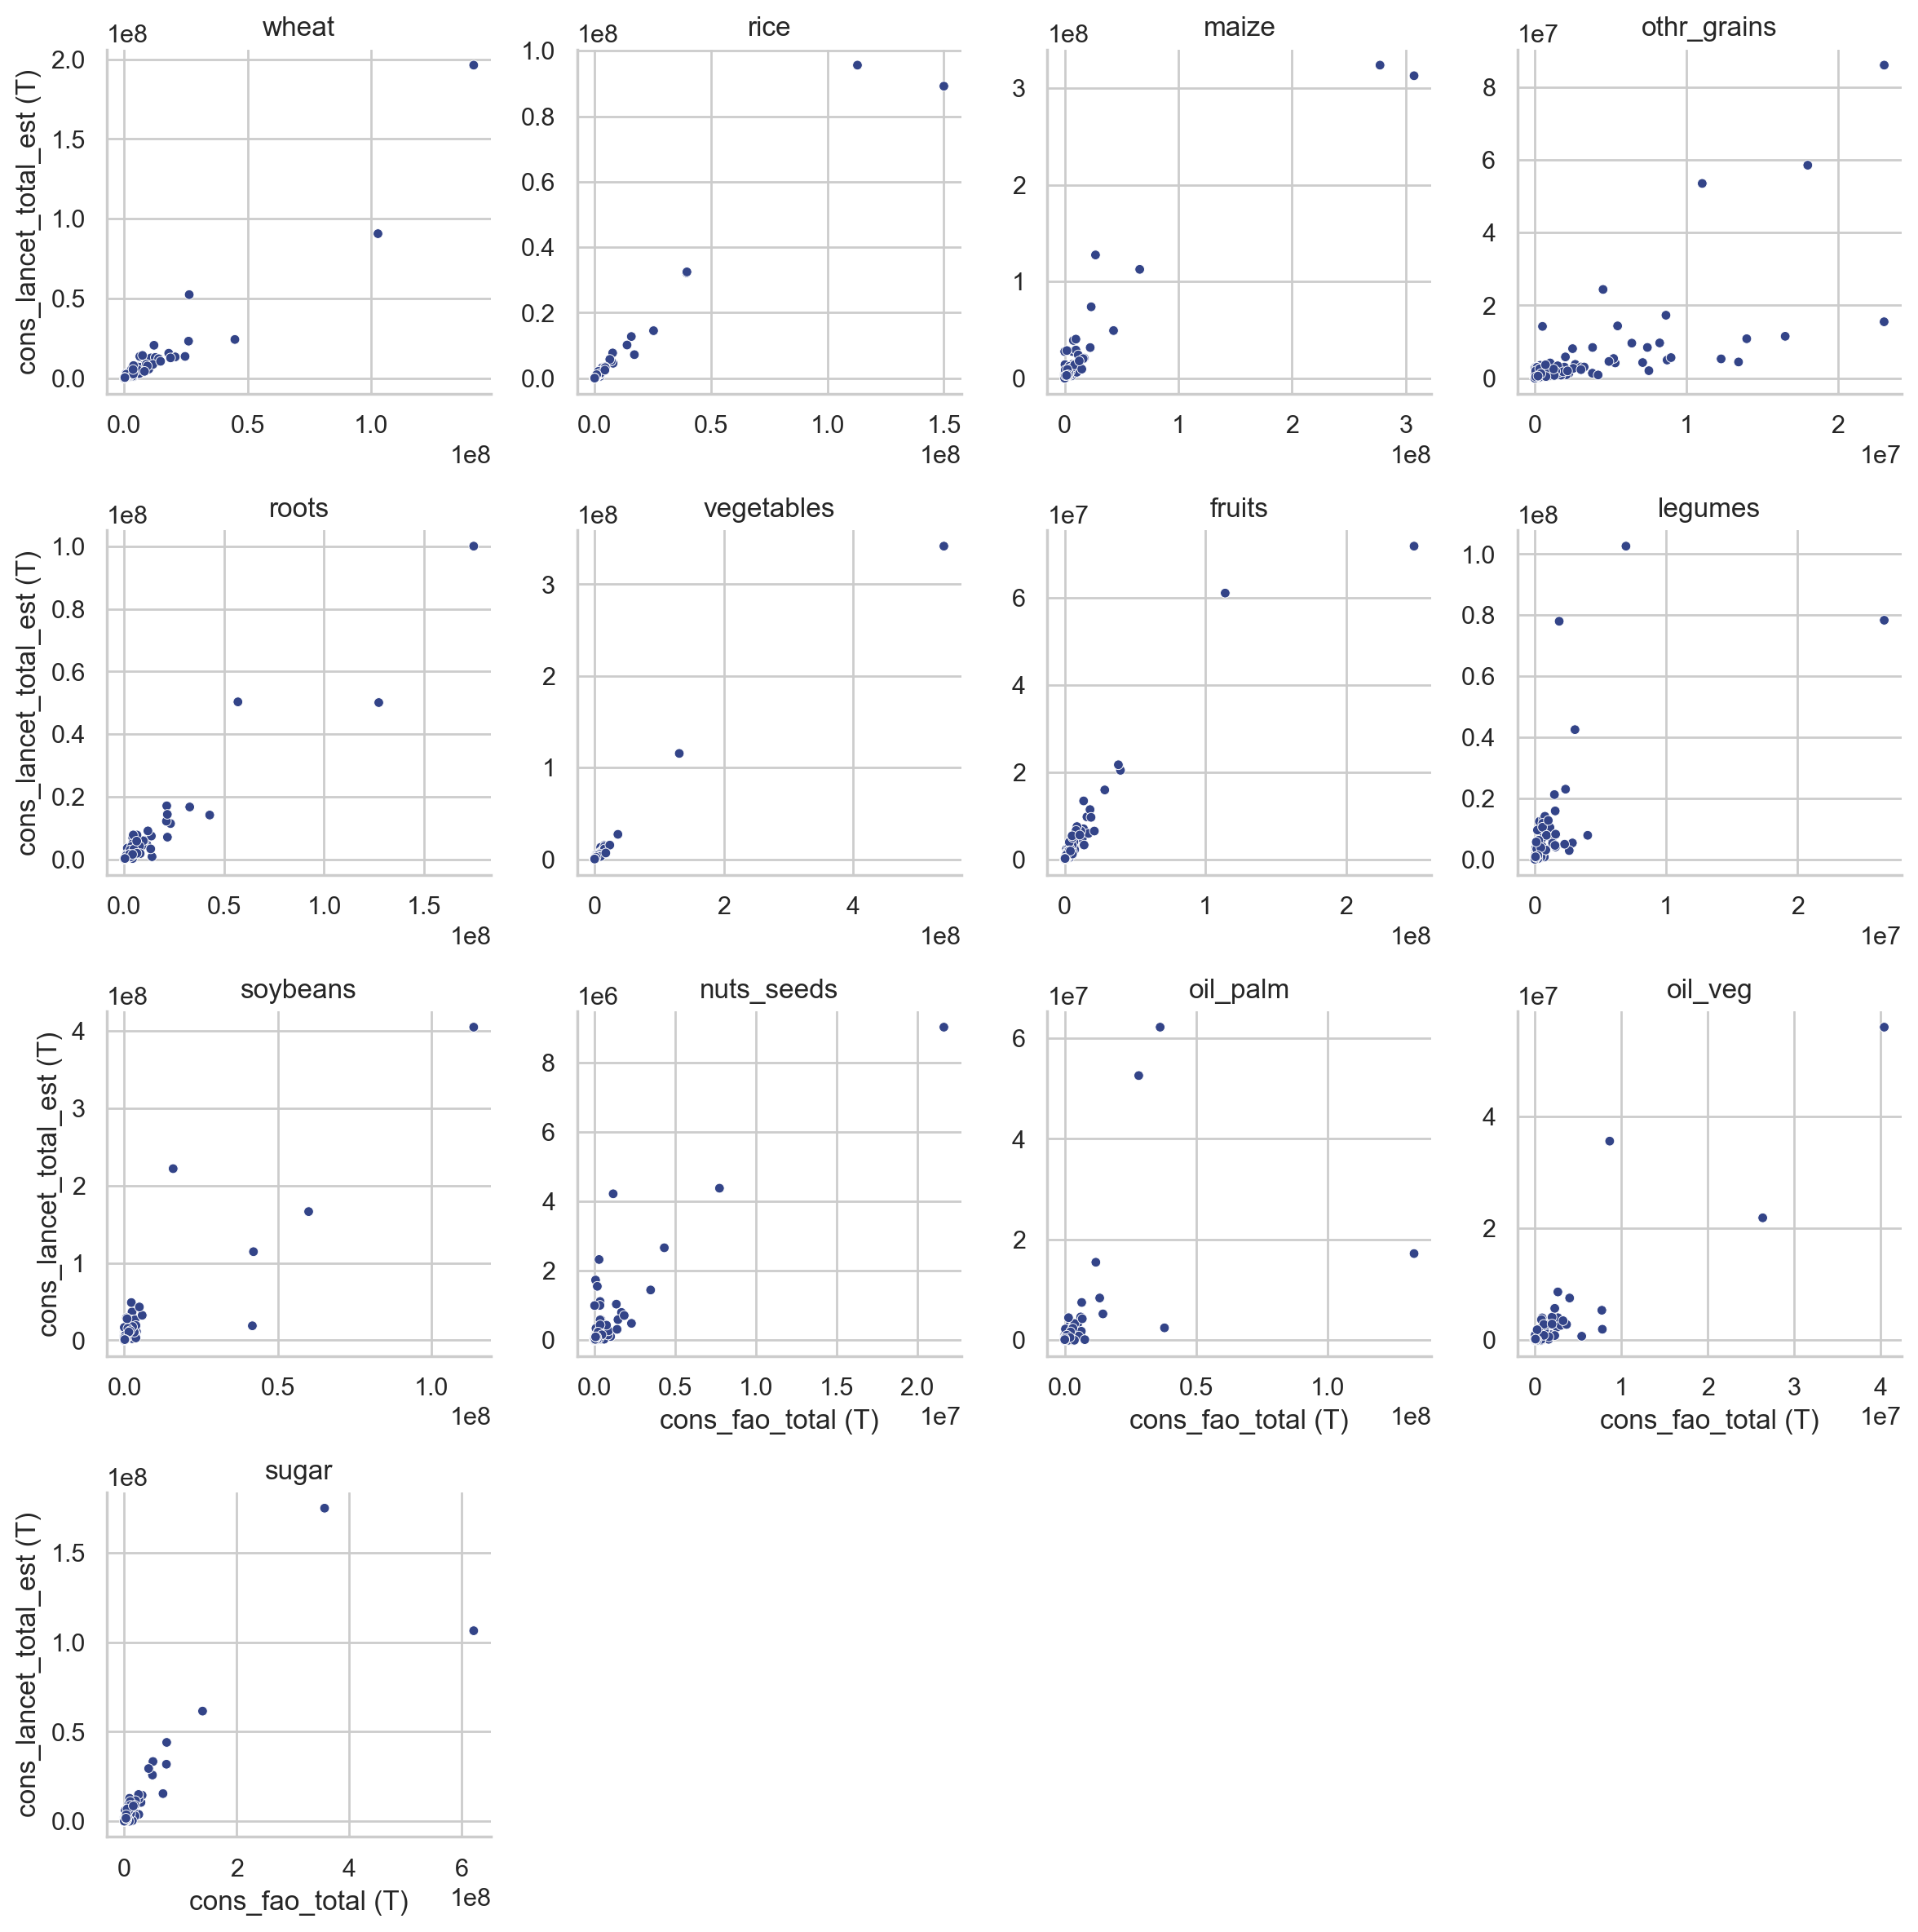

In [25]:
g = sns.relplot(
    data=cons_all,
    x="Consumption", y="cons_lancet_total_est", col="food_group",
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar'],
    col_wrap=4, 
    height=3, facet_kws=dict(sharex=False, sharey=False),
    color="#334488", size=0.3,
    legend=False
)
g.set_titles(col_template="{col_name}")
g.set_ylabels('cons_lancet_total_est (T)')
g.set_xlabels('cons_fao_total (T)')

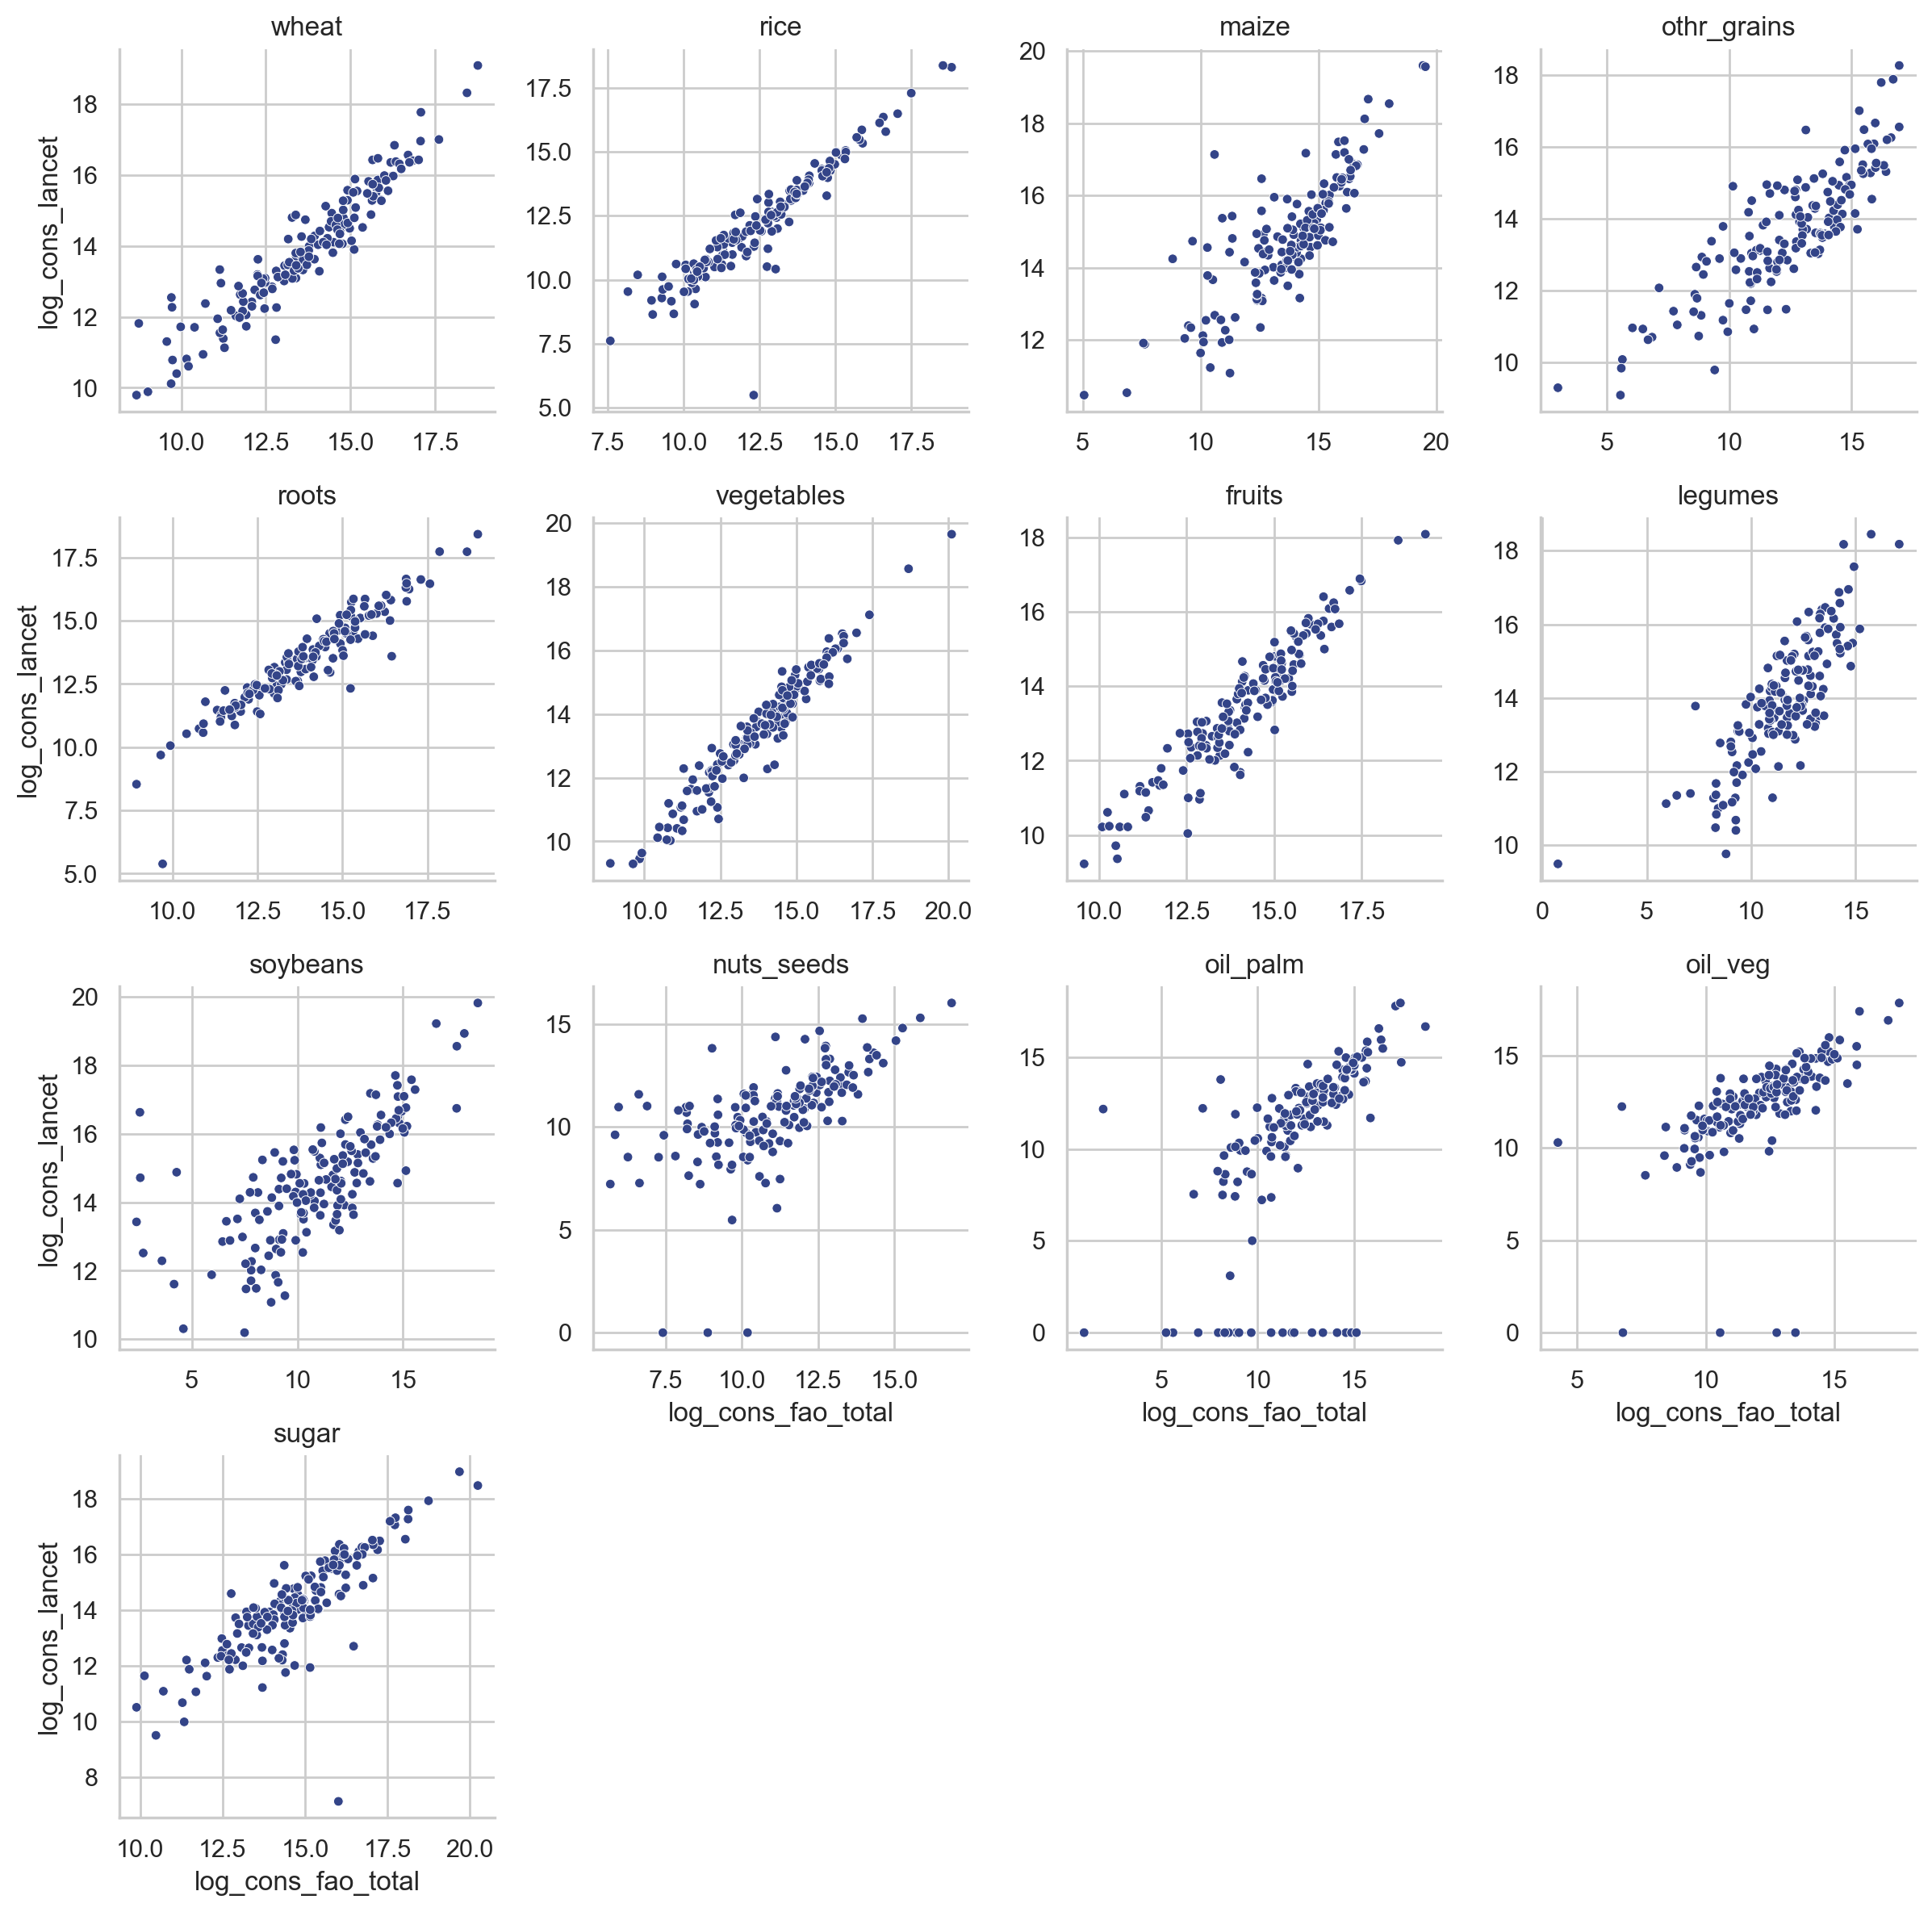

In [24]:
g = sns.relplot(
    data=cons_all,
    x="log_cons_fao", y="log_cons_lancet", col="food_group",
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar'],
    col_wrap=4, 
    height=3, facet_kws=dict(sharex=False, sharey=False),
    color="#334488", size=0.3,
    legend=False
)
g.set_titles(col_template="{col_name}")
g.set_ylabels('log_cons_lancet')
g.set_xlabels('log_cons_fao_total')